# Spatial Transcriptomics Cluster Validation for HM-OT

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np

import sys
import os
import importlib
import torch
sys.path.append(os.path.abspath(".."))

import src.HiddenMarkovOT as HiddenMarkovOT
import src.utils.util_LR as util_LR
from src.utils.util_LR import convert_adata
import src.plotting as plotting


ERROR! Session/line number was not unique in database. History logging moved to new session 5421


In [2]:
import random

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return

seed_everything(1)

In [3]:
'''
filehandles_embryo_adata = [
                            '/scratch/gpfs/ph3641/mouse_embryo/E11.5_E1S1.MOSTA.h5ad', \
                            '/scratch/gpfs/ph3641/mouse_embryo/E12.5_E1S1.MOSTA.h5ad', \
                            '/scratch/gpfs/ph3641/mouse_embryo/E13.5_E1S1.MOSTA.h5ad'
                            ]

timepoints = [ 'E11.5', 'E12.5', 'E13.5'] 

# Load adatas and set count layer and timepoints
print('Loading mouse-embryo AnnDatas')
adatas = []
for i, fh in enumerate(filehandles_embryo_adata):
    adata = sc.read_h5ad(fh)
    adata.X = adata.layers['count']
    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]
    adatas.append(adata)

# Find intersection of genes across all adatas
common_genes = set(adatas[0].var.index)
for adata in adatas[1:]:
    common_genes &= set(adata.var.index)
common_genes = list(common_genes)

# Subset each adata to the common genes
adatas = [adata[:, common_genes] for adata in adatas]
adata_pairs = []

print('Starting PCA')

# Compute pairwise PCA (so it's scalable) for each AnnData (t, t+1)
for i in range(len(adatas) - 1):
    ad1, ad2 = adatas[i], adatas[i+1]
    t1, t2 = timepoints[i], timepoints[i+1]
    
    # 1) Normalize + log-transform both slices independently
    joint = ad.concat([ad1, ad2], join='inner')
    sc.pp.normalize_total(joint)
    sc.pp.log1p(joint)
    sc.pp.pca(joint, n_comps=30)
    # Free up memory by clearing X and heavy layers
    joint.X = None
    if 'count' in joint.layers:
        del joint.layers['count']
    adata_pairs.append(joint)

print('PCA Finished!')
'''

"\nfilehandles_embryo_adata = [\n                            '/scratch/gpfs/ph3641/mouse_embryo/E11.5_E1S1.MOSTA.h5ad',                             '/scratch/gpfs/ph3641/mouse_embryo/E12.5_E1S1.MOSTA.h5ad',                             '/scratch/gpfs/ph3641/mouse_embryo/E13.5_E1S1.MOSTA.h5ad'\n                            ]\n\ntimepoints = [ 'E11.5', 'E12.5', 'E13.5'] \n\n# Load adatas and set count layer and timepoints\nprint('Loading mouse-embryo AnnDatas')\nadatas = []\nfor i, fh in enumerate(filehandles_embryo_adata):\n    adata = sc.read_h5ad(fh)\n    adata.X = adata.layers['count']\n    adata.obs['timepoint'] = [timepoints[i]] * adata.shape[0]\n    adatas.append(adata)\n\n# Find intersection of genes across all adatas\ncommon_genes = set(adatas[0].var.index)\nfor adata in adatas[1:]:\n    common_genes &= set(adata.var.index)\ncommon_genes = list(common_genes)\n\n# Subset each adata to the common genes\nadatas = [adata[:, common_genes] for adata in adatas]\nadata_pairs = []\n\nprint

In [4]:
# Load precomputed PCA-transformed AnnData pairs

filehandles_pca_pairs = [
    '/scratch/gpfs/ph3641/mouse_embryo/pca_pairs/embryo_pair_E11.5_E12.5.h5ad',
    '/scratch/gpfs/ph3641/mouse_embryo/pca_pairs/embryo_pair_E12.5_E13.5.h5ad'
]

adata_pairs = [sc.read_h5ad(fh) for fh in filehandles_pca_pairs]


/home/ph3641/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ph3641/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
import pandas as pd


adata_11_5 = sc.read_h5ad('/scratch/gpfs/ph3641/mouse_embryo/E11.5_E1S1.MOSTA.h5ad')
adata_12_5 = sc.read_h5ad('/scratch/gpfs/ph3641/mouse_embryo/E12.5_E1S1.MOSTA.h5ad')

adata_11_5.obsm['spatial'][:, 0] *= -1
adata_12_5.obsm['spatial'][:, 0] *= -1


In [6]:
# Subset to Cavity cells
cavity_cells = adata_12_5[adata_12_5.obs['annotation'] == 'Cavity']

# Check total counts (UMIs) per cell
cavity_counts = cavity_cells.X.sum(axis=1)

# Convert to 1D numpy array if it's sparse
import numpy as np
if hasattr(cavity_counts, 'A1'):
    cavity_counts = cavity_counts.A1  # for sparse matrix

# Print summary stats
print(f"Number of cavity cells: {len(cavity_counts)}")
print(f"Total counts per cell (min, median, max): {np.min(cavity_counts):.1f}, {np.median(cavity_counts):.1f}, {np.max(cavity_counts):.1f}")

Number of cavity cells: 6431
Total counts per cell (min, median, max): 41.3, 1830.7, 3176.9


In [15]:
adata_11_5_brain = adata_11_5[adata_11_5.obs['annotation'] == 'Brain'].copy()
adata_12_5_brain = adata_12_5[adata_12_5.obs['annotation'] == 'Brain'].copy()

Available markers: ['Mki67', 'Dek', 'Hes6', 'Nefm', 'Tubb3', 'Ina', 'Map2', 'Mapt', 'Nefl', 'Elavl3', 'Uchl1', 'mt-Co1', 'Rab3a']


/tmp/ipykernel_1063923/2786701267.py:24: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


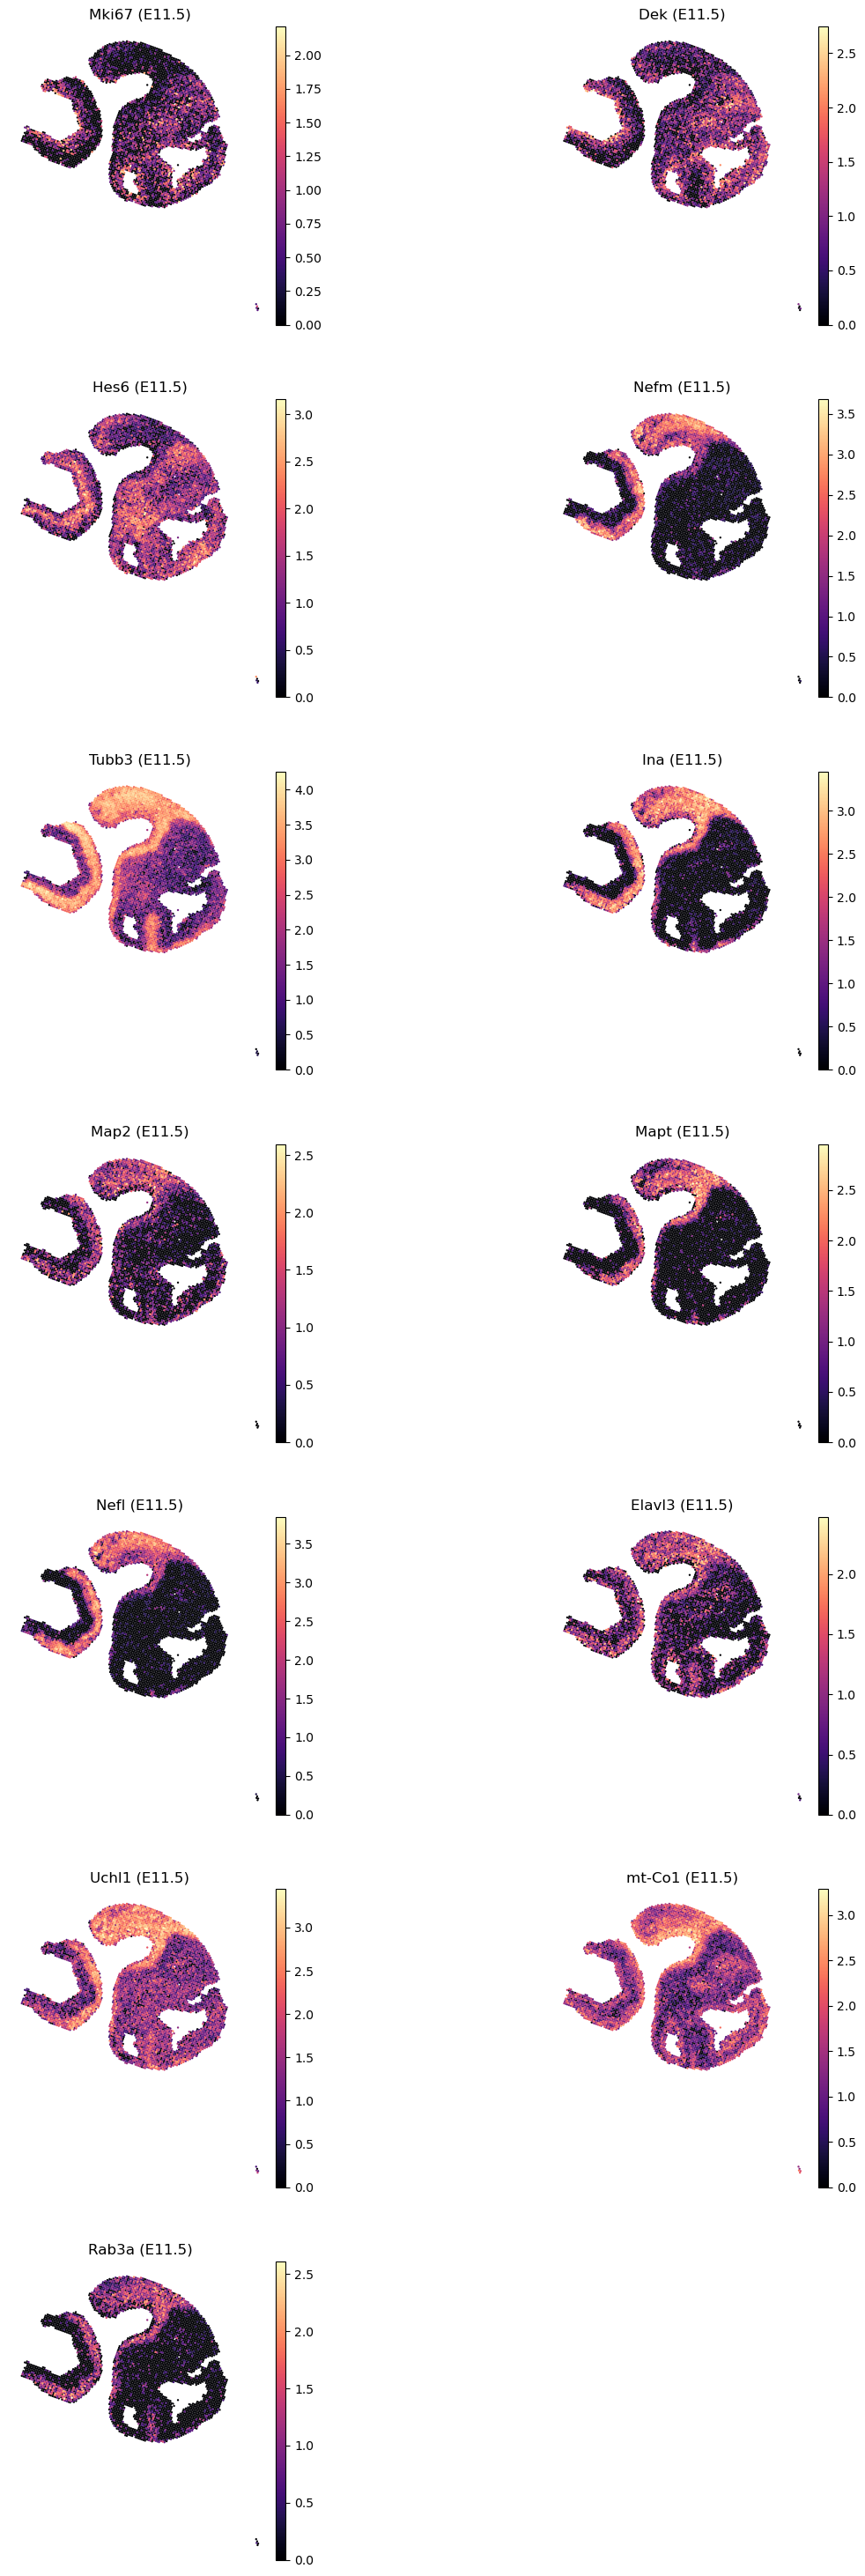

/tmp/ipykernel_1063923/2786701267.py:38: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


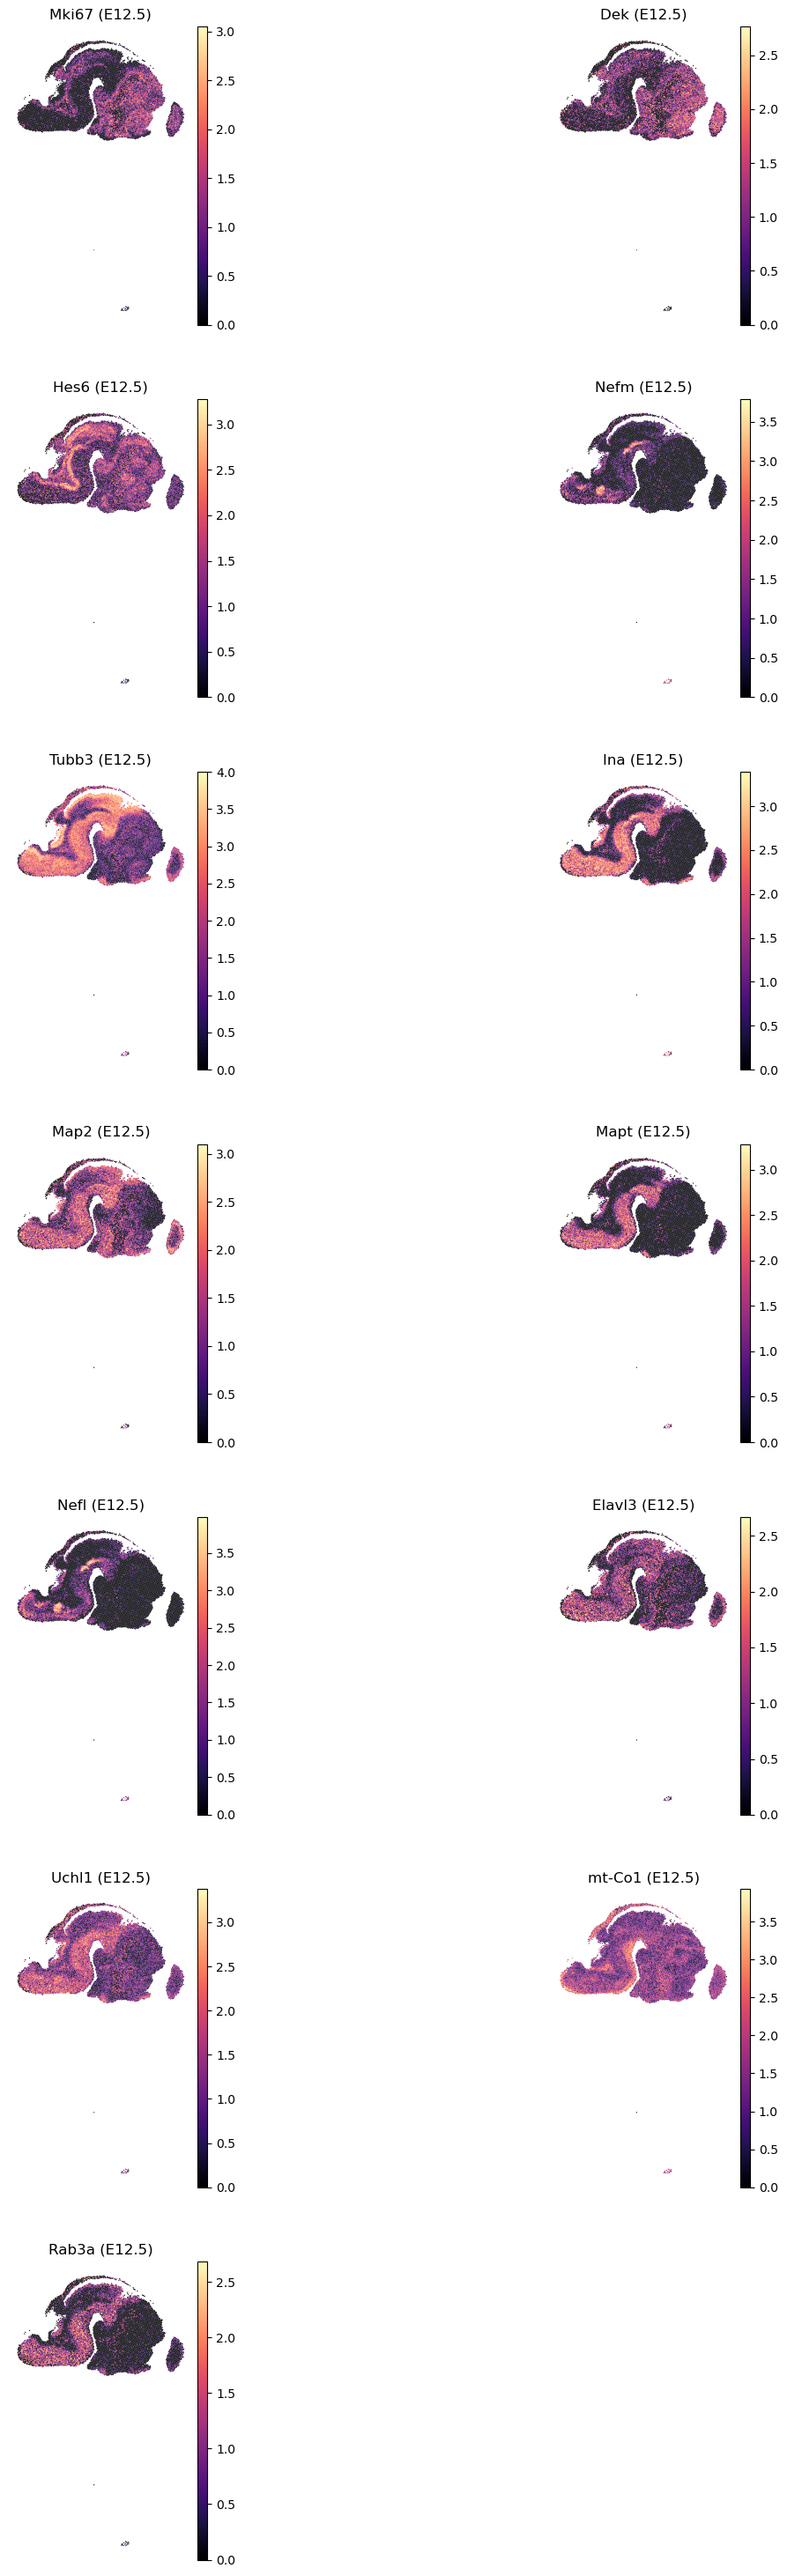

In [19]:
import scanpy as sc

# Define marker genes to visualize (adjust as needed)
marker_genes = ['Mki67', 'Dek', 'Hes6',
                'Nefm',
             'Tubb3',
             'Ina',
            'Map2',
             'Mapt',
             'Nefl',
             'Elavl3',
             'Uchl1',
             'mt-Co1',
             'Rab3a']

# Check which markers exist in data
available_markers = [g for g in marker_genes if g in adata_11_5_brain.var_names]
print(f"Available markers: {available_markers}")

# Optionally set resolution
dpi = 150

# Plot spatial expression on E11.5
sc.pl.spatial(
    adata_11_5_brain,
    color=available_markers,
    ncols=2,
    spot_size=1,
    cmap='magma',
    size=1.2,
    title=[f"{g} (E11.5)" for g in available_markers],
    show=True,
    save='E11_5.pdf',
    frameon=False,
)

# Plot spatial expression on E12.5
sc.pl.spatial(
    adata_12_5_brain,
    color=available_markers,
    ncols=2,
    spot_size=1,
    cmap='magma',
    size=1.2,
    title=[f"{g} (E12.5)" for g in available_markers],
    show=True,
    save='E12_5.pdf',
    frameon=False,
)

Available markers: ['Sox2', 'Mki67', 'Ube2c']


/tmp/ipykernel_2768086/2741866003.py:50: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


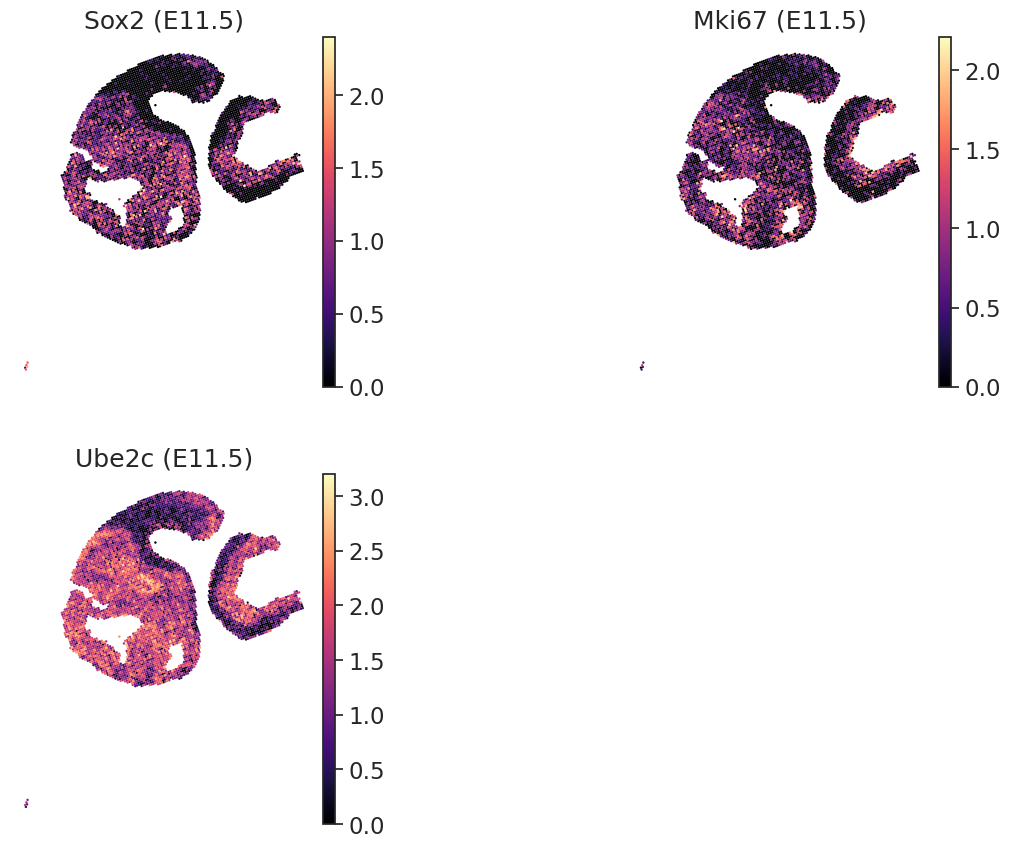

/tmp/ipykernel_2768086/2741866003.py:64: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


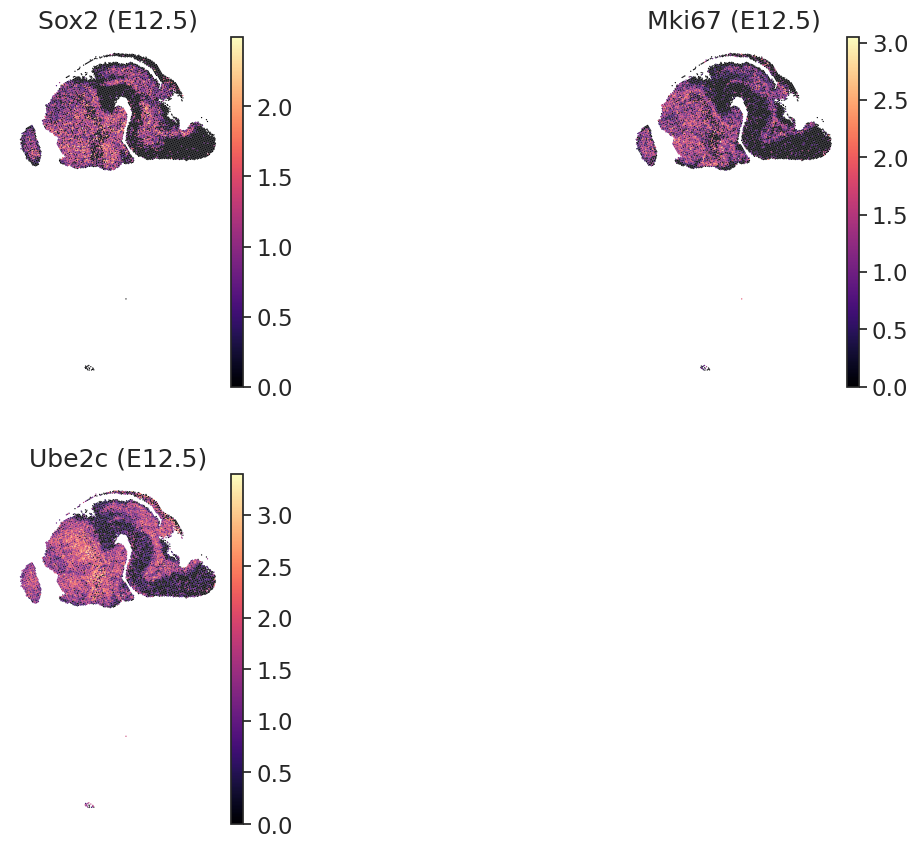

In [15]:
'''
marker_genes = ['Sox2',
                'Mki67',
                'Dek',
                'Ccnd1',
               'Eif4g1',
               'Top2a',
               'Tpx2',
               'Ube2c',
               'Hes5',
               'Hes6',
               'Fabp7',
               'Vim',
               'Gadd45g',
               'Cd24a',
               'Stmn1/2',
               'Sox11',
               'Nsg1',
               'Bex2',
               'Nefm',
               'Map2',
               'Mapt',
               'Nefl',
               'Elavl3']'''
# mitotic
marker_genes = ['Sox2',
                'Mki67',
               'Ube2c']
'''
marker_genes = [
               'Hes6',
               'Gadd45g']'''


'''
marker_genes =[
               'Cd24a',
               'Mapt',
               'Nefl',
               'Elavl3']'''

# Check which markers exist in data
available_markers = [g for g in marker_genes if g in adata_11_5_brain.var_names]
print(f"Available markers: {available_markers}")

# Optionally set resolution
dpi = 150

# Plot spatial expression on E11.5
sc.pl.spatial(
    adata_11_5_brain,
    color=available_markers,
    ncols=2,
    spot_size=1,
    cmap='magma',
    size=1.2,
    title=[f"{g} (E11.5)" for g in available_markers],
    show=True,
    save='E11_5_mitotic.pdf',
    frameon=False,
)

# Plot spatial expression on E12.5
sc.pl.spatial(
    adata_12_5_brain,
    color=available_markers,
    ncols=2,
    spot_size=1,
    cmap='magma',
    size=1.2,
    title=[f"{g} (E12.5)" for g in available_markers],
    show=True,
    save='E12_5_mitotic.pdf',
    frameon=False,
)

